In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np

import gymnasium as gym  
from gymnasium import spaces
from gym_anytrading.envs import StocksEnv
from gym_anytrading.envs.trading_env import Actions, Positions

data = yf.download("AAPL", start="2010-01-01", end="2025-01-01")

# Adding MA50
data[("MA50", "AAPL")] = data[("Close", "AAPL")].rolling(50).mean()

# Adding RSI
data[("RSI", "AAPL")] = ta.rsi(data[("Close", "AAPL")], length=14)

# Adding MACD
macd = ta.macd(data[("Close", "AAPL")])
data[("MACD", "AAPL")] = macd["MACD_12_26_9"]
data[("MACD_signal", "AAPL")] = macd["MACDs_12_26_9"]
data[("MACD_hist", "AAPL")] = macd["MACDh_12_26_9"]

# Adding Bollinger Bands
#print(bbands.columns)
bbands = ta.bbands(data[("Close", "AAPL")])
data[("BB_upper", "AAPL")] = bbands["BBU_5_2.0"]
data[("BB_middle", "AAPL")] = bbands["BBM_5_2.0"]
data[("BB_lower", "AAPL")] = bbands["BBL_5_2.0"]

data.dropna(inplace=True)

# Flatten multi-level column index
data.columns = data.columns.droplevel(1)  # Drop 'AAPL' level
data = data.reset_index()

# Reorder columns if needed
data = data[[
    "Date", "Open", "High", "Low", "Close", "Volume",
    "MA50", "RSI",
    "MACD", "MACD_signal", "MACD_hist",
    "BB_upper", "BB_middle", "BB_lower"
]]

# Set date as index
data.set_index("Date", inplace=True)

split_date = "2021-01-01"
train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
# ------------------ 3. Define Custom Trading Environment ------------------

class MyTradingEnv(StocksEnv):
    def __init__(self, df, window_size, frame_bound):
        super().__init__(df=df, window_size=window_size, frame_bound=frame_bound)
        self.returns = []
        self._prev_total_profit = 1.0
        self._trade_count = 0

    def reset(self, seed=None, options=None):
        observation, info = super().reset(seed=seed, options=options)
        self.returns = []
        self._prev_total_profit = 1.0
        self._trade_count = 0
        return observation, info

    def _process_data(self):
        prices = self.df.loc[:, "Close"].to_numpy()
        features_df = self.df[[
            "Close",
            "MA50",
            "RSI",
            "MACD",
            "MACD_signal",
            "MACD_hist",
            "BB_upper",
            "BB_middle",
            "BB_lower"
        ]]
        prices = prices[self.frame_bound[0] - self.window_size:self.frame_bound[1]]
        features = features_df.iloc[self.frame_bound[0] - self.window_size:self.frame_bound[1]].to_numpy()
        return prices.astype(np.float32), features.astype(np.float32)

    def _sharpe_ratio(self):
        returns = np.array(self.returns[-30:])  # Use the last 30 steps
        if len(returns) < 2 or np.std(returns) == 0:
            return 0.0
        return (np.mean(returns) / (np.std(returns) + 1e-8)) * np.sqrt(252)

    def _calculate_reward(self, action):
        trade = (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        )
        # Update returns list
        current_return = (self._total_profit / self._prev_total_profit) - 1
        self.returns.append(current_return)
        self._prev_total_profit = self._total_profit

        if trade:
            self._trade_count += 1

        sharpe = self._sharpe_ratio()
        penalty = 0.001 if trade else 0.0
        return sharpe - penalty

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Noisy Linear Layer (from Rainbow DQN)
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / self.in_features**0.5
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / self.in_features**0.5)
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / self.out_features**0.5)

    def reset_noise(self):
        self.weight_epsilon.normal_()
        self.bias_epsilon.normal_()

    def forward(self, input):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(input, weight, bias)

In [4]:
class RainbowLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim, n_atoms=51, v_min=-10, v_max=10):
        super().__init__()
        self.n_atoms = n_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (n_atoms - 1)
        self.support = torch.linspace(v_min, v_max, n_atoms)
        self.action_dim = action_dim

        # LSTM for sequential feature extraction
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # Dueling architecture
        self.advantage = nn.Sequential(
            NoisyLinear(hidden_dim, 128), nn.ReLU(),
            NoisyLinear(128, action_dim * n_atoms)
        )
        self.value = nn.Sequential(
            NoisyLinear(hidden_dim, 128), nn.ReLU(),
            NoisyLinear(128, n_atoms)
        )

    def forward(self, x, hidden=None):
        # x shape: (batch, seq_len, features)
        lstm_out, _ = self.lstm(x, hidden)
        x = lstm_out[:, -1, :]  # use last LSTM output

        adv = self.advantage(x).view(-1, self.action_dim, self.n_atoms)
        val = self.value(x).view(-1, 1, self.n_atoms)

        q_atoms = val + adv - adv.mean(dim=1, keepdim=True)
        q_dist = F.softmax(q_atoms, dim=2)  # Convert to probability distribution
        return q_dist

    def reset_noise(self):
        for layer in self.advantage:
            if isinstance(layer, NoisyLinear):
                layer.reset_noise()
        for layer in self.value:
            if isinstance(layer, NoisyLinear):
                layer.reset_noise()

In [5]:
import random
from collections import deque, namedtuple
import numpy as np
import torch

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha
        self.Transition = namedtuple('Transition', ('obs', 'action', 'reward', 'next_obs', 'done'))

    def add(self, obs, action, reward, next_obs, done):
        max_prio = self.priorities.max() if self.buffer else 1.0
        transition = self.Transition(obs, action, reward, next_obs, done)

        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition

        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        # Convert batch to tensors
        obs = torch.tensor(np.array([s.obs for s in samples]), dtype=torch.float32)
        actions = torch.tensor([s.action for s in samples], dtype=torch.int64).unsqueeze(-1)
        rewards = torch.tensor([s.reward for s in samples], dtype=torch.float32).unsqueeze(-1)
        next_obs = torch.tensor(np.array([s.next_obs for s in samples]), dtype=torch.float32)
        dones = torch.tensor([s.done for s in samples], dtype=torch.float32).unsqueeze(-1)
        weights = torch.tensor(weights, dtype=torch.float32).unsqueeze(-1)

        return obs, actions, rewards, next_obs, dones, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio

In [8]:
import torch.optim as optim

# Hyperparameters
seq_len = 10  # window_size
feature_dim = 9  # number of features in observation
hidden_dim = 64
action_dim = 3  # Buy, Sell, Hold
batch_size = 64
n_atoms = 51
v_min = -10
v_max = 10
gamma = 0.99
lr = 1e-4
buffer_capacity = 100_000
beta_start = 0.4
alpha = 0.6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and target network
model = RainbowLSTMNet(input_dim=feature_dim, hidden_dim=hidden_dim,
                       action_dim=action_dim, n_atoms=n_atoms,
                       v_min=v_min, v_max=v_max).to(device)
target_model = RainbowLSTMNet(input_dim=feature_dim, hidden_dim=hidden_dim,
                              action_dim=action_dim, n_atoms=n_atoms,
                              v_min=v_min, v_max=v_max).to(device)

target_model.load_state_dict(model.state_dict())

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Replay buffer
replay_buffer = PrioritizedReplayBuffer(capacity=buffer_capacity, alpha=alpha)

# Support (for distributional loss)
support = torch.linspace(v_min, v_max, n_atoms).to(device)

 10%|▉         | 9997/100000 [40:25<6:43:22,  3.72it/s]

Checkpoint saved at step 10000


 10%|█         | 10001/100000 [40:27<8:47:43,  2.84it/s]

🔍 Step 10000: Eval reward = 0.00, Profit = 1.0000


 20%|█▉        | 19997/100000 [1:25:35<6:08:15,  3.62it/s]

Checkpoint saved at step 20000


 20%|██        | 20001/100000 [1:25:37<7:37:43,  2.91it/s]

🔍 Step 20000: Eval reward = 34.30, Profit = 1.4405


 30%|██▉       | 29997/100000 [2:10:40<5:11:06,  3.75it/s]

Checkpoint saved at step 30000


 30%|███       | 30001/100000 [2:10:42<6:33:36,  2.96it/s]

🔍 Step 30000: Eval reward = -184.31, Profit = 0.9172


 40%|███▉      | 39997/100000 [2:55:43<4:48:12,  3.47it/s]

Checkpoint saved at step 40000


 40%|████      | 40001/100000 [2:55:45<5:54:41,  2.82it/s]

🔍 Step 40000: Eval reward = -159.30, Profit = 0.8878


 50%|████▉     | 49997/100000 [3:40:59<3:45:46,  3.69it/s]

Checkpoint saved at step 50000


 50%|█████     | 50001/100000 [3:41:01<4:43:12,  2.94it/s]

🔍 Step 50000: Eval reward = 88.43, Profit = 1.0254


 60%|█████▉    | 59997/100000 [4:26:14<3:00:46,  3.69it/s]

Checkpoint saved at step 60000


 60%|██████    | 60001/100000 [4:26:16<3:48:23,  2.92it/s]

🔍 Step 60000: Eval reward = -42.51, Profit = 0.9950


 70%|██████▉   | 69997/100000 [5:11:25<2:14:05,  3.73it/s]

Checkpoint saved at step 70000


 70%|███████   | 70001/100000 [5:11:27<2:50:24,  2.93it/s]

🔍 Step 70000: Eval reward = -551.25, Profit = 0.6948


 80%|███████▉  | 79997/100000 [5:56:43<1:31:37,  3.64it/s]

Checkpoint saved at step 80000


 80%|████████  | 80001/100000 [5:56:45<1:53:52,  2.93it/s]

🔍 Step 80000: Eval reward = -1708.78, Profit = 0.3804


 90%|████████▉ | 89997/100000 [6:42:01<46:05,  3.62it/s]  

Checkpoint saved at step 90000


 90%|█████████ | 90001/100000 [6:42:03<57:42,  2.89it/s]

🔍 Step 90000: Eval reward = 75.43, Profit = 1.2025


100%|██████████| 100000/100000 [7:27:19<00:00,  3.73it/s]


Training complete.
Trained Rainbow model saved.
Time taken: 447.33 minutes


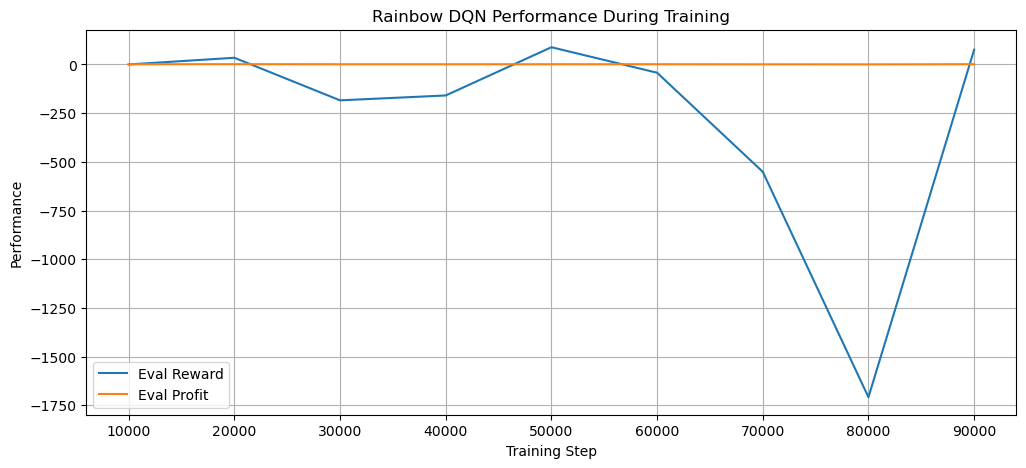

In [9]:
import tqdm
import time
start_time = time.time()

def evaluate_model(model, env, support):
    eval_env = MyTradingEnv(df=test_data, window_size=seq_len, frame_bound=(seq_len, len(test_data)))
    state, _ = eval_env.reset()
    total_reward = 0.0
    model.eval()
    while True:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_dist = model(state_tensor)
            q_values = torch.sum(q_dist * support, dim=2)
            action = torch.argmax(q_values, dim=1).item()

        state, reward, terminated, truncated, info = eval_env.step(action)
        total_reward += reward
        if terminated or truncated:
            return total_reward, info.get('total_profit', 0.0)

train_env = MyTradingEnv(df=train_data, window_size=seq_len, frame_bound=(seq_len, len(train_data)))
test_env = MyTradingEnv(df=test_data, window_size=seq_len, frame_bound=(seq_len, len(test_data)))

obs, _ = train_env.reset()

num_steps = 100_000
target_update_freq = 1000
train_start = 1000
train_freq = 4

epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995

step = 0
episode_reward = 0
total_rewards = []

eval_steps = []
eval_rewards = []
eval_profits = []

for step in tqdm.trange(num_steps):
    model.train()
    # Prepare observation shape: (seq_len, features) -> (1, seq_len, features)
    state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        q_dist = model(state)  # shape: (1, actions, atoms)
        q_values = torch.sum(q_dist * support, dim=2)
        if random.random() < epsilon:
            action = random.randint(0, action_dim - 1)
        else:
            action = torch.argmax(q_values, dim=1).item()

    next_obs, reward, terminated, truncated, _ = train_env.step(action)
    done = terminated or truncated

    # Store experience
    replay_buffer.add(obs, action, reward, next_obs, done)
    obs = next_obs
    episode_reward += reward

    if done:
        obs, _ = train_env.reset()
        total_rewards.append(episode_reward)
        episode_reward = 0
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Train model
    if step > train_start and step % train_freq == 0 and len(replay_buffer.buffer) >= batch_size:
        model.reset_noise()
        target_model.reset_noise()

        # Sample from buffer
        obs_batch, action_batch, reward_batch, next_obs_batch, done_batch, indices, weights = replay_buffer.sample(batch_size)

        obs_batch = obs_batch.to(device)
        next_obs_batch = next_obs_batch.to(device)
        reward_batch = reward_batch.to(device)
        done_batch = done_batch.to(device)
        action_batch = action_batch.to(device)
        weights = weights.to(device)

        # Current Q distribution
        dist = model(obs_batch)
        dist = dist.gather(1, action_batch.unsqueeze(-1).expand(-1, -1, n_atoms)).squeeze(1)

        with torch.no_grad():
            # Next Q distribution
            next_dist = target_model(next_obs_batch)
            next_q = torch.sum(next_dist * support, dim=2)
            best_actions = torch.argmax(next_q, dim=1)
            next_dist = next_dist[range(batch_size), best_actions]

            # Distributional Bellman projection
            Tz = reward_batch + (1 - done_batch) * (gamma ** 1) * support
            Tz = Tz.clamp(min=v_min, max=v_max)
            b = (Tz - v_min) / model.delta_z
            l = b.floor().long()
            u = b.ceil().long()

            proj_dist = torch.zeros_like(next_dist)
            for i in range(batch_size):
                for j in range(n_atoms):
                    lj = l[i, j]
                    uj = u[i, j]
                    if lj == uj:
                        proj_dist[i, lj] += next_dist[i, j]
                    else:
                        proj_dist[i, lj] += next_dist[i, j] * (uj - b[i, j])
                        proj_dist[i, uj] += next_dist[i, j] * (b[i, j] - lj)

        log_pred = torch.log(dist.clamp(min=1e-5))
        loss_per_sample = -(proj_dist * log_pred).sum(1)
        loss = (loss_per_sample * weights.squeeze()).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update priorities
        replay_buffer.update_priorities(indices, loss_per_sample.detach().cpu().numpy())

    # Update target network
    if step % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())
    
    # Save checkpoint every 10k steps
    if step % 10_000 == 0 and step > 0:
        checkpoint_path = f"rainbow_checkpoint_step_{step}.pt"
        torch.save({
            'step': step,
            'model_state_dict': model.state_dict(),
            'target_model_state_dict': target_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epsilon': epsilon
        }, checkpoint_path)
        print(f"Checkpoint saved at step {step}")
        
        # Evaluate current model
        reward_eval, profit_eval = evaluate_model(model, test_env, support)
        eval_steps.append(step)
        eval_rewards.append(reward_eval)
        eval_profits.append(profit_eval)
        print(f"🔍 Step {step}: Eval reward = {reward_eval:.2f}, Profit = {profit_eval:.4f}")

print("Training complete.")
torch.save(model.state_dict(), 'rainbow_lstm_model.pt')
print("Trained Rainbow model saved.")
print(f"Time taken: {(time.time() - start_time)/60:.2f} minutes")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(eval_steps, eval_rewards, label="Eval Reward")
plt.plot(eval_steps, eval_profits, label="Eval Profit")
plt.xlabel("Training Step")
plt.ylabel("Performance")
plt.title("Rainbow DQN Performance During Training")
plt.legend()
plt.grid(True)
plt.show()

✅ Test completed
📊 Final Info: {'total_reward': -308.7190193457784, 'total_profit': 0.837906189069354, 'position': <Positions.Short: 0>}


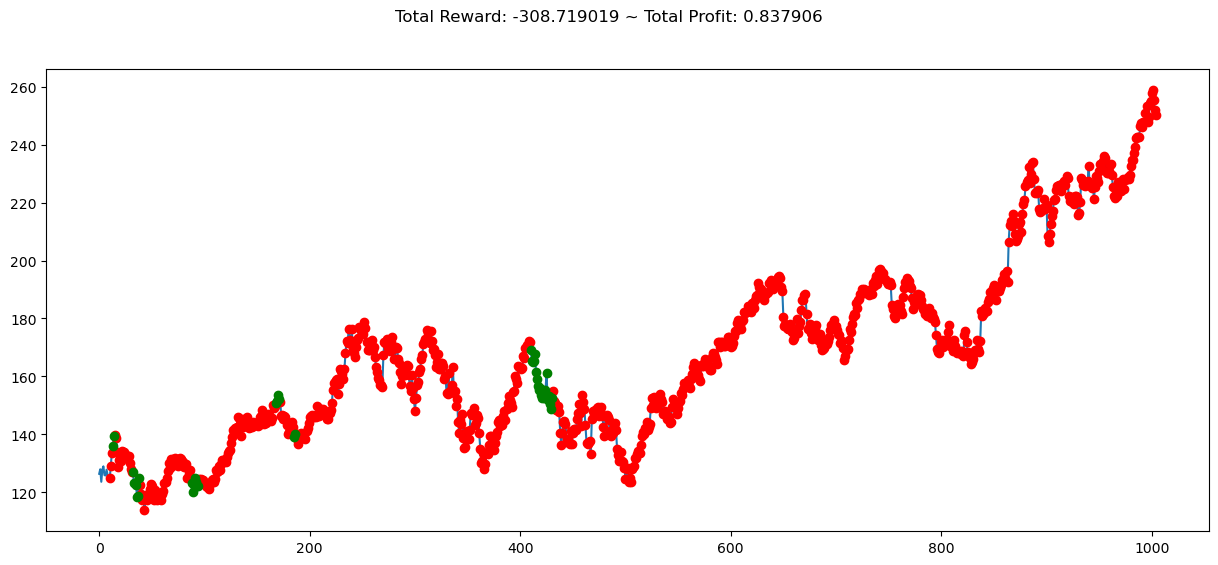

In [15]:
# Evaluation on test data
test_env = MyTradingEnv(df=test_data, window_size=seq_len, frame_bound=(seq_len, len(test_data)))
state, _ = test_env.reset()
done = False

model.eval()  # Set model to eval mode

while not done:
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_dist = model(state_tensor)
        q_values = torch.sum(q_dist * support, dim=2)
        action = torch.argmax(q_values, dim=1).item()

    next_state, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    state = next_state

# Plot results
print("✅ Test completed")
print("📊 Final Info:", info)

plt.figure(figsize=(15, 6))
test_env.render_all()
plt.show()

📊 Final Evaluation — Reward: 34.30, Profit: 1.4405


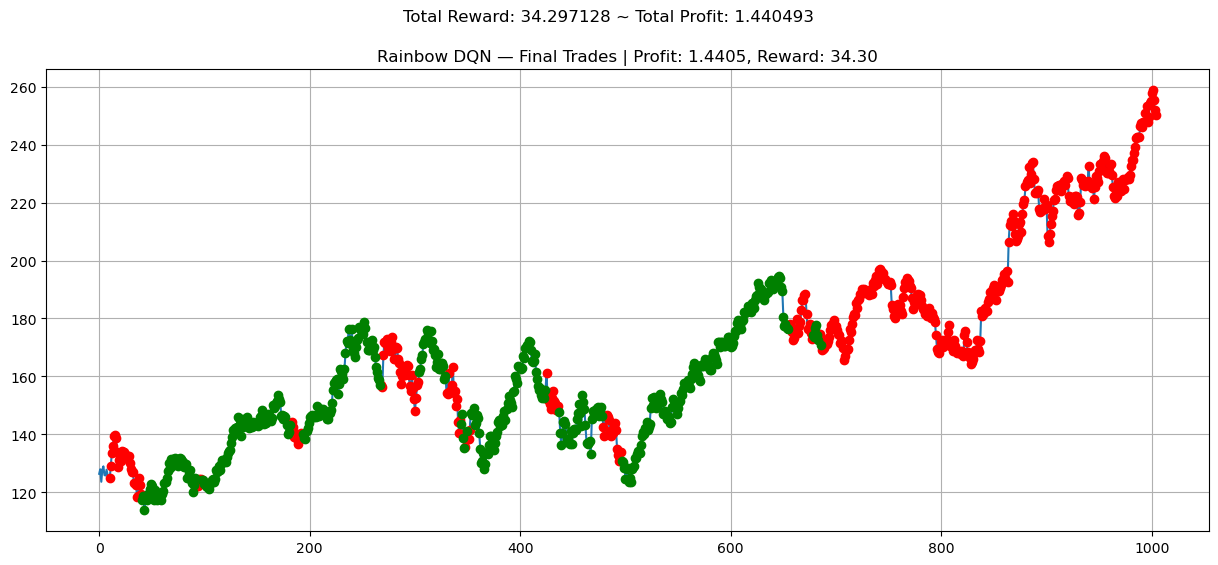

In [21]:
# Load the saved checkpoint
checkpoint = torch.load("rainbow_checkpoint_step_20000.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Re-initialize the test environment
test_env = MyTradingEnv(df=test_data, window_size=seq_len, frame_bound=(seq_len, len(test_data)))

# Run evaluation
def evaluate_model(model, env, support):
    state, _ = env.reset()
    total_reward = 0.0
    while True:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_dist = model(state_tensor)
            q_values = torch.sum(q_dist * support, dim=2)
            action = torch.argmax(q_values, dim=1).item()

        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated:
            return total_reward, info.get('total_profit', 0.0)

# Evaluate
reward, profit = evaluate_model(model, test_env, support)
print(f"📊 Final Evaluation — Reward: {reward:.2f}, Profit: {profit:.4f}")

import matplotlib.pyplot as plt

# Plot test trades (after evaluation)
plt.figure(figsize=(15, 6))
plt.cla()
test_env.render_all()
plt.title(f"Rainbow DQN — Final Trades | Profit: {profit:.4f}, Reward: {reward:.2f}")
plt.grid(True)
plt.show()